In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf

# Data Preparation

In [34]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


In [36]:
# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

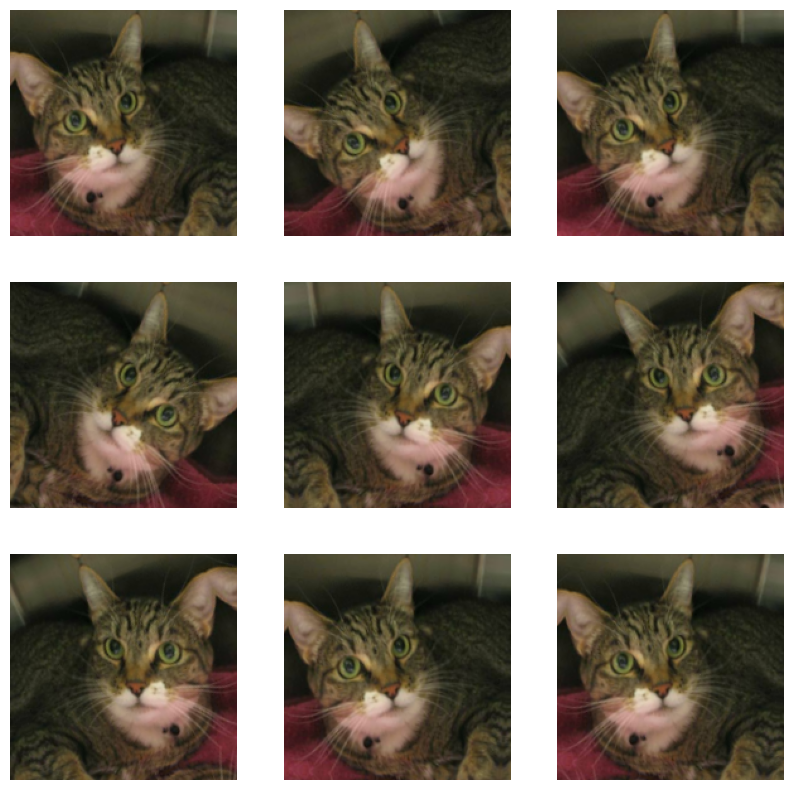

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [38]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Cross Entropy

In [39]:
def make_model_ce(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(
        1,
        activation="sigmoid",
        bias_initializer=tf.keras.initializers.Zeros()
    )(x)
    
    return keras.Model(inputs, outputs)

model_ce = make_model_ce(input_shape=image_size + (3,))

model_ce.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 90, 90, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 90, 90, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,357,857 (16.62 MB)

 Trainable params: 4,357,633 (16.62 MB)

 Non-trainable params: 224 (896.00 B)

In [40]:
epochs = 25

callbacks_ce = [
    keras.callbacks.ModelCheckpoint("checkpoints/ce/save_at_{epoch}.keras"),
]
model_ce.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history_ce = model_ce.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks_ce,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 765ms/step - accuracy: 0.4978 - loss: 1.6192 - val_accuracy: 0.4957 - val_loss: 0.6932
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 778ms/step - accuracy: 0.5419 - loss: 0.6856 - val_accuracy: 0.6232 - val_loss: 0.6807
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 775ms/step - accuracy: 0.5743 - loss: 0.6711 - val_accuracy: 0.6458 - val_loss: 0.6601
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 778ms/step - accuracy: 0.5771 - loss: 0.6660 - val_accuracy: 0.6749 - val_loss: 0.6266
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 784ms/step - accuracy: 0.5971 - loss: 0.6523 - val_accuracy: 0.6934 - val_loss: 0.6079
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 782ms/step - accuracy: 0.5956 - loss: 0.6523 - val_accuracy: 0.6864 - val_loss: 0.6131
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 784ms/step - accuracy: 0.6026 - loss: 0.6463 - val_accuracy: 0.7265 - val_loss: 0.5904
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 117s 788ms/step - accuracy: 0.6065 -

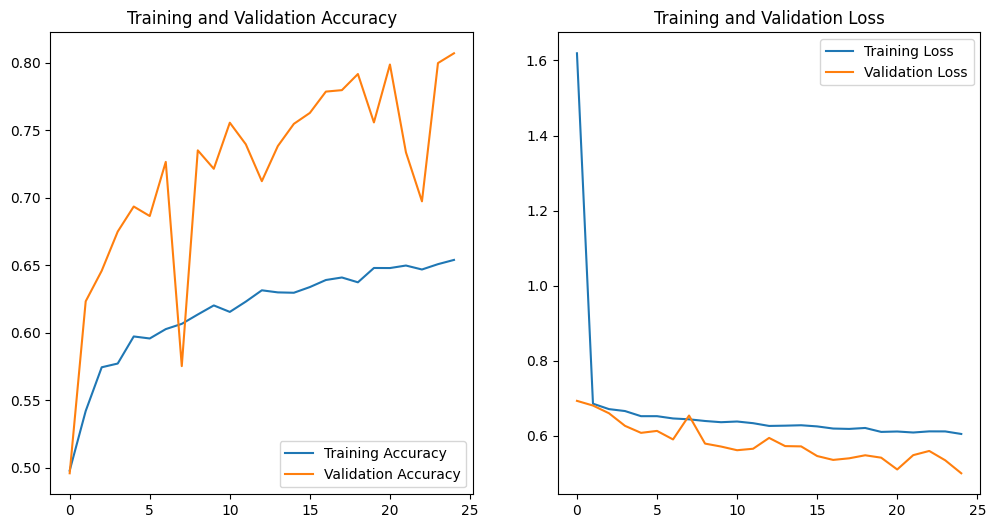

In [41]:
acc = history_ce.history["accuracy"]
val_acc = history_ce.history["val_accuracy"]

loss = history_ce.history["loss"]
val_loss = history_ce.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
This image is 28.61% cat and 71.39% dog.


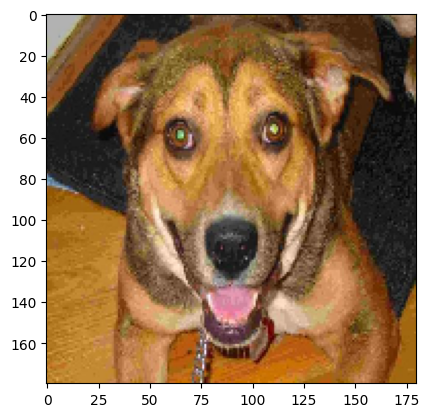

In [44]:
img = keras.utils.load_img("PetImages/Dog/99.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model_ce.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [43]:
all_labels = []
all_preds = []
class_names = ["Cat", "Dog"]

for images, labels in val_ds:
    preds = model_ce.predict(images, verbose=0)  # shape (batch_size, 1)
    all_labels.append(labels.numpy())
    all_preds.append(preds.squeeze())  # flatten to (batch_size,)

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Per-class statistics
classes = np.unique(all_labels)
for c in classes:
    idx = all_labels == c
    class_preds = all_preds[idx]
    print(f"Class {c} ({class_names[c]}):")
    print(f"  Number of samples: {len(class_preds)}")
    print(f"  Mean predicted probability: {class_preds.mean():.4f}")
    print(f"  Accuracy: {(class_preds > 0.5).mean():.4f}")
    print()

Class 0 (Cat):
  Number of samples: 2322
  Mean predicted probability: 0.4580
  Accuracy: 0.2313

Class 1 (Dog):
  Number of samples: 2362
  Mean predicted probability: 0.7196
  Accuracy: 0.8446



# Logistic Loss

In [45]:
def make_model_log(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # CHANGED: no sigmoid, starts near 0 so loss doesnt initally overflow
    outputs = layers.Dense(
        1,
        activation="linear",
        kernel_initializer=keras.initializers.RandomNormal(mean=0.02, stddev=0.05),
        bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
    )(x)

    return keras.Model(inputs, outputs)


model_log = make_model_log(input_shape=image_size + (3,))

model_log.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 90, 90, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 90, 90, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,357,857 (16.62 MB)

 Trainable params: 4,357,633 (16.62 MB)

 Non-trainable params: 224 (896.00 B)

In [46]:
def logistic_loss(y_true, f_x):
    m = tf.cast(y_true, tf.float32)
    exponent = (1.0 - 2.0 * m) * f_x
    loss = tf.nn.softplus(exponent)  # stable log(1 + exp(exponent))
    return tf.reduce_mean(loss)

def bayes_accuracy(y_true, f_x):
    # Convert raw logK to probability
    p = tf.sigmoid(f_x)
    preds = tf.cast(p > 0.5, tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(y_true, tf.float32)), tf.float32))

In [48]:
epochs = 25

callbacks_log = [
    keras.callbacks.ModelCheckpoint("checkpoints/log/save_at_{epoch}.keras"),
]
model_log.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss=logistic_loss,
    metrics=[bayes_accuracy], 
)

history_log = model_log.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks_log,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 775ms/step - bayes_accuracy: 0.5018 - loss: 0.6933 - val_bayes_accuracy: 0.4956 - val_loss: 0.6932
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 109s 738ms/step - bayes_accuracy: 0.4964 - loss: 0.6933 - val_bayes_accuracy: 0.4956 - val_loss: 0.6932
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 109s 736ms/step - bayes_accuracy: 0.4997 - loss: 0.6934 - val_bayes_accuracy: 0.4956 - val_loss: 0.6933
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 730ms/step - bayes_accuracy: 0.5011 - loss: 0.6933 - val_bayes_accuracy: 0.4956 - val_loss: 0.6933
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 107s 725ms/step - bayes_accuracy: 0.4988 - loss: 0.6933 - val_bayes_accuracy: 0.4956 - val_loss: 0.6932
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 726ms/step - bayes_accuracy: 0.4996 - loss: 0.6934 - val_bayes_accuracy: 0.4956 - val_loss: 0.6932
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 727ms/step - bayes_accuracy: 0.5025 - loss: 0.6933 - val_bayes_accuracy: 0.4956 - val_loss:

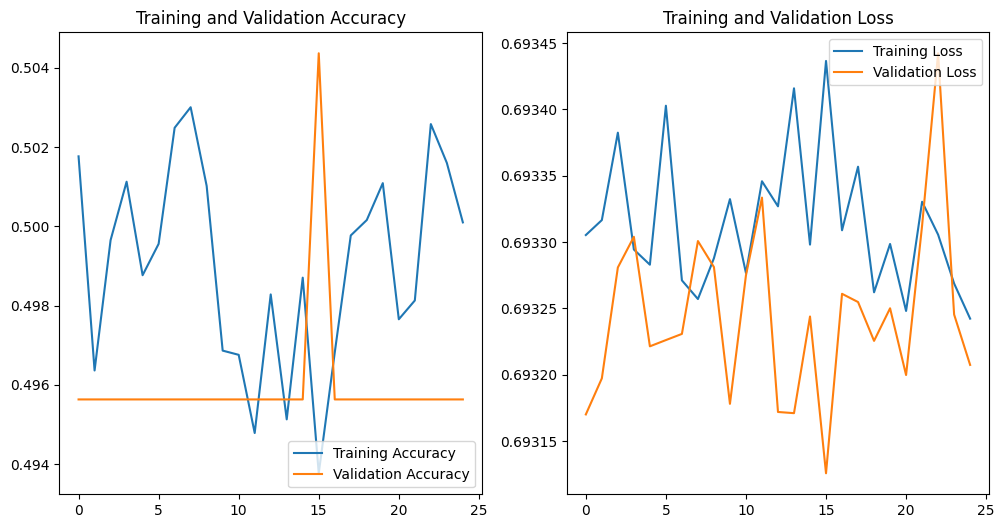

In [49]:
acc = history_log.history["bayes_accuracy"]
val_acc = history_log.history["val_bayes_accuracy"]

loss = history_log.history["loss"]
val_loss = history_log.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()
